# Prelim

Dataset downloaded from : https://support.10xgenomics.com/single-cell-multiome-atac-gex/datasets/1.0.0/pbmc_unsorted_10k

Data is available at `s3://fh-pi-setty-m-eco-public/single-cell-primers/multiome/`

ArchR preprocessing script: https://github.com/settylab/single-cell-primers/blob/main/scripts/PBMC-mulitome-ATAC-ArchR-preprocessing.R

Review the notebook `PBMC-RNA-standalone.ipynb` for setup instructions.

In [23]:
import os
import pandas as pd
import numpy as np

import scanpy as sc
import pyranges as pr
import warnings

In [24]:
import palantir 
import phenograph
import harmony

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
%matplotlib inline
sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Utility functions

In [26]:
def log_transform(ad, ps=0.1):
    ad.X.data = np.log2(ad.X.data + ps) - np.log2(ps)

In [27]:
def pyranges_from_strings(pos_list):
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)).str.split('-').str.get(1)
    
    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    
    return gr

# Load data

## ATAC

In [28]:
data_dir = '/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/tcell-multiome-data/ArchR/tcell-dep_multiome_atac/export/'

Load all the exported results from ArchR

### Peaks data

In [29]:
# Peaks data
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

In [30]:
# Cell and peak information
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
imputed_scores = pd.read_csv(data_dir + 'imputed_scores.csv')
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)
peaks.head()


,seqnames,start,end,width,strand,score,replicateScoreQuantile,groupScoreQuantile,Reproducibility,GroupReplicate,distToGeneStart,nearestGene,peakType,distToTSS,nearestTSS,GC,idx,N
chr1:804692-805192,chr1,804692,805192,501,*,10.60886,0.536,0.311,2,C16._.tcell_dep_multiome_1,12428,FAM87B,Distal,9,uc057awz.1,0.4012,1,0
chr1:816092-816592,chr1,816092,816592,501,*,21.58958,0.551,0.414,2,C2._.tcell_dep_multiome_1,1028,FAM87B,Promoter,1028,uc031tlt.2,0.2854,2,0
chr1:817084-817584,chr1,817084,817584,501,*,71.52040,0.917,0.872,2,C4._.tcell_dep_multiome_2,36,FAM87B,Promoter,36,uc031tlt.2,0.4790,3,0
chr1:821678-822178,chr1,821678,822178,501,*,4.52263,0.194,0.045,2,C8._.tcell_dep_multiome_1,3209,LINC01128,Distal,3209,uc057axa.1,0.5309,4,0
chr1:822507-823007,chr1,822507,823007,501,*,5.40291,0.264,0.081,2,C8._.tcell_dep_multiome_1,2380,LINC01128,Distal,2380,uc057axa.1,0.5609,5,0


In [47]:
np.shape(peaks)

(272770, 18)

In [45]:
imputed_scores

,Unnamed: 0,tcell_dep_multiome_1.GTGAGCGAGTCTCACC.1,tcell_dep_multiome_1.ATTAGCTCATTGTCCT.1,tcell_dep_multiome_1.TATTAGGTCGTTTCCA.1,tcell_dep_multiome_1.GTCATCCTCTAATCCT.1,tcell_dep_multiome_1.TTAGCAGGTGAGACTC.1,tcell_dep_multiome_1.TTGAGGCGTTGGCCGA.1,tcell_dep_multiome_1.ATGGCTGTCCTTCTAG.1,tcell_dep_multiome_1.ACCTCACTCGCAGGCT.1,tcell_dep_multiome_1.ATGACAACATGCATAT.1,...,tcell_dep_multiome_2.GCGCTAGGTCACAAAT.1,tcell_dep_multiome_2.ATTGCTCGTAACTACG.1,tcell_dep_multiome_2.AATCCTAAGCTCCTAC.1,tcell_dep_multiome_2.ATAATGGCATGGAGGC.1,tcell_dep_multiome_2.GTGCTCCGTGAACAAA.1,tcell_dep_multiome_2.CAAGGCTGTGCTGGTG.1,tcell_dep_multiome_2.GCAACAGCAGGACCTT.1,tcell_dep_multiome_2.CTAGTTGCAGTTTGGC.1,tcell_dep_multiome_2.GTACGTAGTATCTGGA.1,tcell_dep_multiome_2.GTACTTCGTTCCATTA.1
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24914,24915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24915,24916,0.072198,0.069749,0.052901,0.021128,0.021617,0.025123,0.031699,0.000693,0.165075,...,0.264468,0.013724,0.012295,0.015071,0.003453,0.015800,0.276736,0.137587,0.006809,0.015236
24916,24917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24917,24918,0.023606,0.054362,0.011104,0.002893,0.013332,0.003905,0.000046,0.003191,0.108090,...,0.148389,0.009261,0.018606,0.004809,0.000062,0.009762,0.095777,0.107752,0.025085,0.007841


In [31]:
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index
for col in peaks.columns:
    ad.var[col] = peaks[col]

/loc/scratch/65784171/ipykernel_8438/1812160205.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = sc.AnnData(counts.T)


In [32]:
ad.X = ad.X.tocsr()

In [49]:
ad.var_names

Index(['chr1:804692-805192', 'chr1:816092-816592', 'chr1:817084-817584',
       'chr1:821678-822178', 'chr1:822507-823007', 'chr1:827300-827800',
       'chr1:830019-830519', 'chr1:831511-832011', 'chr1:838219-838719',
       'chr1:842730-843230',
       ...
       'chrX:155881037-155881537', 'chrX:155881625-155882125',
       'chrX:155885766-155886266', 'chrX:155886540-155887040',
       'chrX:155888149-155888649', 'chrX:155889254-155889754',
       'chrX:155891384-155891884', 'chrX:155893570-155894070',
       'chrX:155899118-155899618', 'chrX:155966816-155967316'],
      dtype='object', length=272770)

### SVD

In [34]:
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

### Metadata

In [35]:
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

In [36]:
ad

AnnData object with n_obs × n_vars = 9605 × 272770
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    obsm: 'X_svd'

### Gene scores

In [37]:
# Gene scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

In [38]:
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [39]:
ad

AnnData object with n_obs × n_vars = 9605 × 272770
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

# Preprocessing

In [40]:
# Leiden and UMAP
warnings.filterwarnings('ignore')
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
warnings.filterwarnings('default')

In [41]:
# Phenograph
ad.obs['phenograph'], _, _ = phenograph.cluster(ad.obsm['X_svd'])
ad.obs['phenograph'] = ad.obs['phenograph'].astype(str)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22735953330993652 seconds


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x152147a51c40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x152147a51c40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

Jaccard graph constructed in 4.13632607460022 seconds
Wrote graph to binary file in 0.23827481269836426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.86759
After 7 runs, maximum modularity is Q = 0.868785
Louvain completed 27 runs in 14.653751850128174 seconds
Sorting communities by size, please wait ...


/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x152147a51c40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x152147a51c40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x15230d53ec40>
  self.pid = os.fork()
/home/cjordan2/.conda/envs/singlecell/lib/python3.8/multiprocessing/popen_fork.py:70:

PhenoGraph completed in 23.29878854751587 seconds


In [42]:
# Diffusion maps
warnings.filterwarnings('ignore')
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(ad.obsm['X_svd'], index=ad.obs_names))
warnings.filterwarnings('default')
ad.obsp['DM_kernel'] = dm_res['kernel']
ad.obsm['DM_EigenVectors']  = dm_res['EigenVectors'].values
ad.uns['DM_EigenValues']  = dm_res['EigenValues'].values

Determing nearest neighbor graph...


# Visualizations

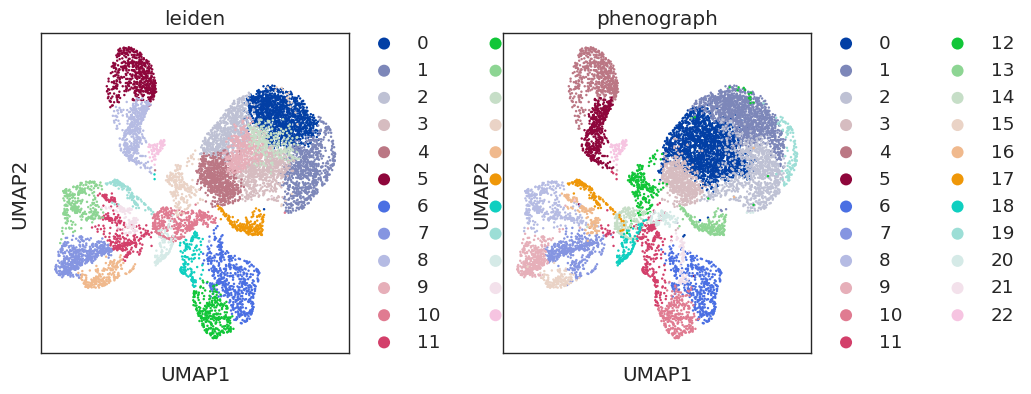

In [43]:
sc.pl.scatter(ad, basis='umap', color=['leiden', 'phenograph'])

# Save

In [44]:
ad

AnnData object with n_obs × n_vars = 9605 × 272770
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums', 'neighbors', 'umap', 'leiden', 'DM_EigenValues', 'leiden_colors', 'phenograph_colors'
    obsm: 'X_svd', 'GeneScores', 'X_umap', 'DM_EigenVectors'
    obsp: 'distances', 'connectivities', 'DM_kernel'

In [23]:
ad.write('/fh/fast/setty_m/user/cjordan2/repositories/single-cell-primers/data/tcell_dep_multiome_atac.h5ad')